In [1]:
# %% Cell 1: Imports, device, and seed
print('Cell 1: Starting imports and device configuration')

import os
import random
import time
from pathlib import Path

import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as transforms
from PIL import Image

import kornia

# Deterministic behavior for reproducibility (may slow training)
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)
print("PyTorch version:", torch.__version__)


Cell 1: Starting imports and device configuration
Using device: cuda
PyTorch version: 2.5.1
Using device: cuda
PyTorch version: 2.5.1


In [2]:
# %% Cell 2: Dataset class for paired CT-MRI images
print("Cell 2: Defining CTMRIDataset (paired loader)")

class CTMRIDataset(Dataset):
    """
    Expects dataset_path to contain two folders:
      - ct/   -> contains CT images
      - mri/  -> contains MRI images
    Filenames must match for pairing (or sorted order used).
    """
    def __init__(self, dataset_path, transform=None, img_size=(256,256), extensions=('.png','.jpg','.jpeg','.bmp','.tif')):
        super().__init__()
        self.dataset_path = Path(dataset_path)
        self.ct_dir = self.dataset_path / "CT"
        self.mri_dir = self.dataset_path / "MRI"
        self.transform = transform
        self.img_size = img_size
        self.extensions = extensions

        if not self.ct_dir.exists() or not self.mri_dir.exists():
            raise RuntimeError(f"CT or MRI folder missing in {dataset_path}. Expected 'ct' and 'mri' subfolders.")

        # list and pair based on sorted filenames
        self.ct_files = sorted([p for p in self.ct_dir.iterdir() if p.suffix.lower() in extensions])
        self.mri_files = sorted([p for p in self.mri_dir.iterdir() if p.suffix.lower() in extensions])

        if len(self.ct_files) == 0 or len(self.mri_files) == 0:
            raise RuntimeError("No images found in ct/ or mri/ subfolders.")

        # If counts differ, pair until min length and warn
        if len(self.ct_files) != len(self.mri_files):
            print(f"Warning: ct and mri counts differ ({len(self.ct_files)} vs {len(self.mri_files)}). Pairing up to min length.")
            min_len = min(len(self.ct_files), len(self.mri_files))
            self.ct_files = self.ct_files[:min_len]
            self.mri_files = self.mri_files[:min_len]

    def __len__(self):
        return len(self.ct_files)

    def _load_image(self, path):
        # Read grayscale, resize, convert to float32 [0,1]
        img = Image.open(path).convert("L")
        if self.img_size is not None:
            img = img.resize(self.img_size, resample=Image.BILINEAR)
        img = np.asarray(img).astype(np.float32) / 255.0
        return img

    def __getitem__(self, idx):
        ct = self._load_image(self.ct_files[idx])
        mri = self._load_image(self.mri_files[idx])

        # Stack channels separately; transform expects tensor in [-1,1]
        if self.transform:
            ct_t = self.transform(ct).float()
            mri_t = self.transform(mri).float()
        else:
            # Default transform: ToTensor-like + Normalize [-1,1]
            ct_t = torch.from_numpy(ct).unsqueeze(0) * 2.0 - 1.0
            mri_t = torch.from_numpy(mri).unsqueeze(0) * 2.0 - 1.0

        return ct_t, mri_t


Cell 2: Defining CTMRIDataset (paired loader)


In [3]:
# %% Cell 3: Model definitions (Generator + Dual Discriminators)
print("Cell 3: Defining model architectures (Generator + Discriminators)")

class Block(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, kernel=3):
        super().__init__()
        padding = kernel // 2
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel, stride, padding),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2, inplace=True)
        )
    def forward(self, x):
        return self.net(x)

class Encoder(nn.Module):
    def __init__(self, in_channels=2, feat=48):
        super().__init__()
        self.net = nn.Sequential(
            Block(in_channels, feat, stride=1),
            Block(feat, feat, stride=2),
            Block(feat, feat, stride=1),
            Block(feat, feat, stride=2),
            Block(feat, feat, stride=1)
        )
    def forward(self, x):
        return self.net(x)

class Decoder(nn.Module):
    def __init__(self, in_channels=48, out_channels=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.ConvTranspose2d(in_channels, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(16, out_channels, kernel_size=3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.net(x)

class Generator(nn.Module):
    def __init__(self, in_channels=2, out_channels=1, feat=48):
        super().__init__()
        self.encoder = Encoder(in_channels, feat)
        self.decoder = Decoder(feat, out_channels)
    def forward(self, x):
        h = self.encoder(x)
        out = self.decoder(h)
        return out

# Discriminator: small conv net. Add option to return features for feature-matching stabilization.
class Discriminator(nn.Module):
    def __init__(self, in_channels=1, return_features=False):
        super().__init__()
        self.return_features = return_features
        layers = []
        layers += [nn.Conv2d(in_channels, 64, 4, 2, 1), nn.LeakyReLU(0.2, inplace=True)]
        layers += [nn.Conv2d(64, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.LeakyReLU(0.2, inplace=True)]
        layers += [nn.Conv2d(128, 256, 4, 2, 1), nn.BatchNorm2d(256), nn.LeakyReLU(0.2, inplace=True)]
        layers += [nn.Conv2d(256, 512, 4, 2, 1), nn.BatchNorm2d(512), nn.LeakyReLU(0.2, inplace=True)]
        self.features = nn.Sequential(*layers)
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(512, 1)
        )

    def forward(self, x):
        feat = self.features(x)
        out = self.classifier(feat)
        if self.return_features:
            # return global score and flattened feature map for feature-matching
            return out, feat
        else:
            return out


Cell 3: Defining model architectures (Generator + Discriminators)


In [4]:
# %% Cell 4: DDcGANTrainer class with all methods
print("Cell 4: Defining DDcGANTrainer class")

# Path configuration
RESULTS_DIR = "results/ddcgan_fusion"
SAMPLES_DIR = f"{RESULTS_DIR}/samples"
PLOTS_DIR = f"{RESULTS_DIR}/plots"
CHECKPOINTS_DIR = "checkpoints/intermediate/ddcgan_fusion"
FINAL_MODELS_DIR = "checkpoints/final/ddcgan_fusion"

def weights_init(m):
    """Initialize network weights"""
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

def gradient_penalty(discriminator, real_samples, fake_samples, device):
    """Calculate gradient penalty for WGAN-GP"""
    batch_size = real_samples.shape[0]
    alpha = torch.rand(batch_size, 1, 1, 1).to(device)

    interpolates = (alpha * real_samples + (1 - alpha) * fake_samples).requires_grad_(True)
    d_interpolates = discriminator(interpolates)

    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=torch.ones_like(d_interpolates),
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]

    gradients = gradients.view(gradients.shape[0], -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

class DDcGANTrainer:
    def __init__(self, dataset_path, batch_size=8, lr=0.0002, img_size=(256, 256), device='cuda'):
        self.device = device
        self.batch_size = batch_size
        self.img_size = img_size

        print(f"Initializing trainer with batch_size={batch_size}, lr={lr}, img_size={img_size}")

        # Data preparation
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])  # Normalize to [-1, 1]
        ])

        print("Loading dataset...")
        self.dataset = CTMRIDataset(dataset_path, transform=transform, img_size=img_size)
        self.dataloader = DataLoader(
            self.dataset,
            batch_size=batch_size,
            shuffle=True,
            num_workers=4,
            pin_memory=True
        )

        print("Initializing models...")
        # Initialize models
        self.generator = Generator(in_channels=2, out_channels=1).to(device)
        self.discriminator1 = Discriminator(in_channels=1).to(device)  # Global discriminator
        self.discriminator2 = Discriminator(in_channels=1).to(device)  # Local discriminator

        # Apply weight initialization
        self.generator.apply(weights_init)
        self.discriminator1.apply(weights_init)
        self.discriminator2.apply(weights_init)

        print("Initializing optimizers...")
        # Optimizers
        self.g_optimizer = optim.Adam(self.generator.parameters(), lr=lr, betas=(0.5, 0.999))
        self.d1_optimizer = optim.Adam(self.discriminator1.parameters(), lr=lr, betas=(0.5, 0.999))
        self.d2_optimizer = optim.Adam(self.discriminator2.parameters(), lr=lr, betas=(0.5, 0.999))

        # Loss functions
        self.adversarial_loss = nn.MSELoss()
        self.reconstruction_loss = nn.L1Loss()

        # Training history
        self.g_losses = []
        self.d_losses = []
        self.recon_losses = []
        self.g_adv_losses = []
        self.d1_losses = []
        self.d2_losses = []
        self.epoch_times = []

        print("Trainer initialized successfully!")

    def gradient_loss(self, gen_img, ir_img):
        """Force generator to keep IR edges"""
        gen_grad = kornia.filters.sobel(gen_img)
        ir_grad = kornia.filters.sobel(ir_img)
        return torch.nn.functional.l1_loss(gen_grad, ir_grad)

    def ssim_loss(self, img1, img2):
        """SSIM-based similarity loss"""
        ssim_fn = kornia.losses.SSIMLoss(window_size=11, reduction='mean')
        return ssim_fn(img1, img2)

    def _random_patches(self, img, patch_size=(64,64), num_patches=4):
        """Extract random patches from image for local discriminator"""
        batch_size, c, h, w = img.shape
        patches = []
        for b in range(batch_size):
            for _ in range(num_patches):
                # Random crop
                top = torch.randint(0, h - patch_size[0] + 1, (1,)).item()
                left = torch.randint(0, w - patch_size[1] + 1, (1,)).item()
                patch = img[b:b+1, :, top:top+patch_size[0], left:left+patch_size[1]]
                patches.append(patch)
        if patches:
            return torch.cat(patches, dim=0)
        else:
            return torch.empty(0, c, patch_size[0], patch_size[1], device=img.device)

    def train_epoch(self, epoch):
        start_time = time.time()
        self.generator.train()
        self.discriminator1.train()
        self.discriminator2.train()

        epoch_g_loss = 0.0
        epoch_d_loss = 0.0
        epoch_recon_loss = 0.0
        epoch_g_adv_loss = 0.0
        epoch_d1_loss = 0.0
        epoch_d2_loss = 0.0
        epoch_ir_loss = 0.0
        epoch_ssim_loss = 0.0

        pbar = tqdm(self.dataloader, desc=f'Epoch {epoch}')

        # Updated hyperparameters
        CT_WEIGHT = 0.6     # emphasize CT global anatomy
        MRI_WEIGHT = 0.4    # moderate MRI texture
        PATCH_SIZE = (64,64)
        PATCHES_PER_IMG = 4
        PATCH_ADV_WEIGHT = 0.3   # reduce patch adversarial influence
        USE_GP = False
        GP_WEIGHT = 10.0

        for i, (ct_imgs, mri_imgs) in enumerate(pbar):
            batch_size = ct_imgs.size(0)
            ct_imgs = ct_imgs.to(self.device)
            mri_imgs = mri_imgs.to(self.device)
            input_imgs = torch.cat([ct_imgs, mri_imgs], dim=1)

            # Labels
            real_label = torch.ones(batch_size, 1, device=self.device)
            fake_label = torch.zeros(batch_size, 1, device=self.device)

            # ---------------------
            # Train Discriminators
            # ---------------------
            with torch.no_grad():
                fake_fused = self.generator(input_imgs)

            # D1: Global discriminator — CT as real
            self.d1_optimizer.zero_grad()
            real_pred1 = self.discriminator1(ct_imgs)
            fake_pred1 = self.discriminator1(fake_fused.detach())
            d1_real_loss = self.adversarial_loss(real_pred1, real_label)
            d1_fake_loss = self.adversarial_loss(fake_pred1, fake_label)
            d1_loss = 0.5 * (d1_real_loss + d1_fake_loss)
            if USE_GP:
                gp1 = gradient_penalty(self.discriminator1, ct_imgs, fake_fused.detach(), self.device)
                d1_loss += GP_WEIGHT * gp1
            d1_loss.backward()
            self.d1_optimizer.step()

            # D2: Local discriminator — MRI patches as real
            self.d2_optimizer.zero_grad()
            real_patches = self._random_patches(mri_imgs, patch_size=PATCH_SIZE, num_patches=PATCHES_PER_IMG)
            fake_patches = self._random_patches(fake_fused.detach(), patch_size=PATCH_SIZE, num_patches=PATCHES_PER_IMG)
            rp_batch = real_patches.size(0)
            real_label_p = torch.ones(rp_batch, 1, device=self.device)
            fake_label_p = torch.zeros(rp_batch, 1, device=self.device)

            real_pred2 = self.discriminator2(real_patches)
            fake_pred2 = self.discriminator2(fake_patches)
            d2_real_loss = self.adversarial_loss(real_pred2, real_label_p)
            d2_fake_loss = self.adversarial_loss(fake_pred2, fake_label_p)
            d2_loss = 0.5 * (d2_real_loss + d2_fake_loss)
            if USE_GP:
                gp2 = gradient_penalty(self.discriminator2, real_patches, fake_patches, self.device)
                d2_loss += GP_WEIGHT * gp2
            d2_loss.backward()
            self.d2_optimizer.step()

            total_d_loss = d1_loss.item() + d2_loss.item()

            # -----------------
            # Train Generator
            # -----------------
            self.g_optimizer.zero_grad()
            fused_imgs = self.generator(input_imgs)

            # Adversarial loss: fool both discriminators
            pred1_g = self.discriminator1(fused_imgs)
            pred2_g = self.discriminator2(fused_imgs)
            g_adv_loss = 0.5 * (self.adversarial_loss(pred1_g, real_label) + self.adversarial_loss(pred2_g, real_label))

            # Patch adversarial emphasis (smaller weight)
            fused_patches = self._random_patches(fused_imgs, patch_size=PATCH_SIZE, num_patches=PATCHES_PER_IMG)
            fp_batch = fused_patches.size(0)
            if fp_batch > 0:
                fused_patch_pred = self.discriminator2(fused_patches)
                patch_adv_loss = self.adversarial_loss(fused_patch_pred, torch.ones(fp_batch, 1, device=self.device))
                g_adv_loss += PATCH_ADV_WEIGHT * patch_adv_loss

            # Weighted reconstruction loss
            g_recon_loss = 0.5 * self.reconstruction_loss(fused_imgs, ct_imgs) + \
                        0.5 * self.reconstruction_loss(fused_imgs, mri_imgs)

            # Gradient loss
            g_ir_loss = 0.5 * self.gradient_loss(fused_imgs, ct_imgs) + \
                        0.5 * self.gradient_loss(fused_imgs, mri_imgs)

            # SSIM loss
            g_ssim_loss = 0.5 * self.ssim_loss(fused_imgs, ct_imgs) + \
                        0.5 * self.ssim_loss(fused_imgs, mri_imgs)


            # Total generator loss
            g_loss = g_adv_loss + 10.0 * g_recon_loss + 5.0 * g_ir_loss + 1.0 * g_ssim_loss
            g_loss.backward()
            self.g_optimizer.step()

            # Update metrics
            epoch_g_loss += g_loss.item()
            epoch_d_loss += total_d_loss
            epoch_recon_loss += g_recon_loss.item()
            epoch_g_adv_loss += (g_adv_loss.item() if isinstance(g_adv_loss, torch.Tensor) else float(g_adv_loss))
            epoch_ir_loss += g_ir_loss.item()
            epoch_ssim_loss += g_ssim_loss.item()
            epoch_d1_loss += d1_loss.item()
            epoch_d2_loss += d2_loss.item()

            pbar.set_postfix({
                'G_Loss': f'{g_loss.item():.4f}',
                'D_Loss': f'{total_d_loss:.4f}',
                'Recon_Loss': f'{g_recon_loss.item():.4f}',
                'G_Adv_Loss': f'{(g_adv_loss.item() if isinstance(g_adv_loss, torch.Tensor) else float(g_adv_loss)):.4f}',
                'D1_Loss': f'{d1_loss.item():.4f}',
                'D2_Loss': f'{d2_loss.item():.4f}'
            })

            if i % 100 == 0:
                self.save_sample_images(ct_imgs, mri_imgs, fused_imgs, epoch, i)

        # Average losses
        n_batches = max(1, len(self.dataloader))
        avg_g_loss = epoch_g_loss / n_batches
        avg_d_loss = epoch_d_loss / n_batches
        avg_recon_loss = epoch_recon_loss / n_batches
        avg_g_adv_loss = epoch_g_adv_loss / n_batches
        avg_ir_loss = epoch_ir_loss / n_batches
        avg_ssim_loss = epoch_ssim_loss / n_batches
        avg_d1_loss = epoch_d1_loss / n_batches
        avg_d2_loss = epoch_d2_loss / n_batches
        epoch_time = time.time() - start_time

        # Store history
        self.g_losses.append(avg_g_loss)
        self.d_losses.append(avg_d_loss)
        self.recon_losses.append(avg_recon_loss)
        self.g_adv_losses.append(avg_g_adv_loss)
        self.d1_losses.append(avg_d1_loss)
        self.d2_losses.append(avg_d2_loss)
        self.epoch_times.append(epoch_time)

        print(f"\nEpoch {epoch} Summary:")
        print(f"  Generator Loss: {avg_g_loss:.4f}")
        print(f"  Discriminator Loss: {avg_d_loss:.4f}")
        print(f"  Reconstruction Loss: {avg_recon_loss:.4f}")
        print(f"  Generator Adv Loss: {avg_g_adv_loss:.4f}")
        print(f"  D1 Loss: {avg_d1_loss:.4f}")
        print(f"  D2 Loss: {avg_d2_loss:.4f}")
        print(f"  MRI/CT edge Loss: {avg_ir_loss:.4f}")
        print(f"  SSIM Loss: {avg_ssim_loss:.4f}")
        print(f"  Epoch Time: {epoch_time:.2f}s")

        return avg_g_loss, avg_d_loss

    def save_sample_images(self, ct_imgs, mri_imgs, fused_imgs, epoch, batch_idx):
        """Save sample images during training"""
        os.makedirs(SAMPLES_DIR, exist_ok=True)

        # Take first image from batch
        ct_sample = ct_imgs[0].cpu()
        mri_sample = mri_imgs[0].cpu()
        fused_sample = fused_imgs[0].cpu()

        # Denormalize images and convert to numpy
        ct_sample = (ct_sample + 1) / 2
        mri_sample = (mri_sample + 1) / 2
        fused_sample = (fused_sample + 1) / 2

        # Convert to numpy arrays and ensure proper shape
        ct_np = ct_sample.squeeze().detach().cpu().numpy()
        mri_np = mri_sample.squeeze().detach().cpu().numpy()
        fused_np = fused_sample.squeeze().detach().cpu().numpy()

        # Ensure 2D arrays for grayscale
        if len(ct_np.shape) == 3 and ct_np.shape[0] == 1:
            ct_np = ct_np[0]
        if len(mri_np.shape) == 3 and mri_np.shape[0] == 1:
            mri_np = mri_np[0]
        if len(fused_np.shape) == 3 and fused_np.shape[0] == 1:
            fused_np = fused_np[0]

        # Create comparison plot
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        axes[0].imshow(ct_np, cmap='gray')
        axes[0].set_title('CT')
        axes[0].axis('off')

        axes[1].imshow(mri_np, cmap='gray')
        axes[1].set_title('MRI')
        axes[1].axis('off')

        axes[2].imshow(fused_np, cmap='gray')
        axes[2].set_title('Fused')
        axes[2].axis('off')

        plt.tight_layout()
        plt.savefig(f'{SAMPLES_DIR}/epoch_{epoch}_batch_{batch_idx}.png', dpi=150, bbox_inches='tight')
        plt.close()

    def save_model(self, epoch, path=CHECKPOINTS_DIR):
        """Save model checkpoints"""
        os.makedirs(path, exist_ok=True)

        checkpoint = {
            'epoch': epoch,
            'generator_state_dict': self.generator.state_dict(),
            'discriminator1_state_dict': self.discriminator1.state_dict(),
            'discriminator2_state_dict': self.discriminator2.state_dict(),
            'g_optimizer_state_dict': self.g_optimizer.state_dict(),
            'd1_optimizer_state_dict': self.d1_optimizer.state_dict(),
            'd2_optimizer_state_dict': self.d2_optimizer.state_dict(),
            'g_losses': self.g_losses,
            'd_losses': self.d_losses,
            'recon_losses': self.recon_losses,
            'g_adv_losses': self.g_adv_losses,
            'd1_losses': self.d1_losses,
            'd2_losses': self.d2_losses,
            'epoch_times': self.epoch_times
        }

        torch.save(checkpoint, f'{path}/ddcgan_epoch_{epoch}.pth')
        print(f'Model saved at epoch {epoch}')

    def load_model(self, checkpoint_path):
        """Load model checkpoint"""
        checkpoint = torch.load(checkpoint_path, map_location=self.device)

        self.generator.load_state_dict(checkpoint['generator_state_dict'])
        self.discriminator1.load_state_dict(checkpoint['discriminator1_state_dict'])
        self.discriminator2.load_state_dict(checkpoint['discriminator2_state_dict'])

        self.g_optimizer.load_state_dict(checkpoint['g_optimizer_state_dict'])
        self.d1_optimizer.load_state_dict(checkpoint['d1_optimizer_state_dict'])
        self.d2_optimizer.load_state_dict(checkpoint['d2_optimizer_state_dict'])

        self.g_losses = checkpoint['g_losses']
        self.d_losses = checkpoint['d_losses']
        self.recon_losses = checkpoint['recon_losses']
        self.g_adv_losses = checkpoint['g_adv_losses']
        self.d1_losses = checkpoint['d1_losses']
        self.d2_losses = checkpoint['d2_losses']
        self.epoch_times = checkpoint['epoch_times']

        return checkpoint['epoch']

    def plot_training_metrics(self):
        """Plot all training metrics"""
        os.makedirs(PLOTS_DIR, exist_ok=True)

        epochs = range(1, len(self.g_losses) + 1)

        # Plot 1: Generator and Discriminator losses
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(epochs, self.g_losses, label='Generator Loss')
        plt.plot(epochs, self.d_losses, label='Discriminator Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Generator vs Discriminator Loss')

        # Plot 2: Component losses
        plt.subplot(1, 2, 2)
        plt.plot(epochs, self.recon_losses, label='Reconstruction Loss')
        plt.plot(epochs, self.g_adv_losses, label='Generator Adv Loss')
        plt.plot(epochs, self.d1_losses, label='Discriminator 1 Loss')
        plt.plot(epochs, self.d2_losses, label='Discriminator 2 Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Component Losses')

        plt.tight_layout()
        plt.savefig(f'{PLOTS_DIR}/training_losses.png', dpi=150, bbox_inches='tight')
        plt.show()

        # Plot 3: Epoch times
        plt.figure(figsize=(8, 4))
        plt.plot(epochs, self.epoch_times)
        plt.xlabel('Epoch')
        plt.ylabel('Time (seconds)')
        plt.title('Epoch Training Time')
        plt.savefig(f'{PLOTS_DIR}/epoch_times.png', dpi=150, bbox_inches='tight')
        plt.show()

    def train(self, num_epochs, save_interval=5):
        print(f"Starting training for {num_epochs} epochs... Dataset size: {len(self.dataset)}")
        start_time = time.time()
        best_g_loss = float('inf')   # track best generator loss for saving best sample

        for epoch in range(1, num_epochs + 1):
            g_loss, d_loss = self.train_epoch(epoch)
            print(f"Epoch [{epoch}/{num_epochs}] - G_Loss: {g_loss:.4f}, D_Loss: {d_loss:.4f}")

            # Save model at intervals
            if epoch % save_interval == 0:
                self.save_model(epoch)

            # Save best fusion sample (first batch only)
            with torch.no_grad():
                ct_imgs, mri_imgs = next(iter(self.dataloader))
                ct_imgs = ct_imgs.to(self.device)
                mri_imgs = mri_imgs.to(self.device)
                input_imgs = torch.cat([ct_imgs, mri_imgs], dim=1)
                fused_imgs = self.generator(input_imgs)
                if g_loss < best_g_loss:
                    best_g_loss = g_loss
                    best_sample_path = f"{SAMPLES_DIR}/best_fusion_epoch_{epoch}.png"
                    os.makedirs(SAMPLES_DIR, exist_ok=True)
                    ct_sample = ((ct_imgs[0].cpu() + 1) / 2).squeeze().numpy()
                    mri_sample = ((mri_imgs[0].cpu() + 1) / 2).squeeze().numpy()
                    fused_sample = ((fused_imgs[0].cpu() + 1) / 2).squeeze().numpy()
                    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
                    axes[0].imshow(ct_sample, cmap='gray'); axes[0].set_title('CT'); axes[0].axis('off')
                    axes[1].imshow(mri_sample, cmap='gray'); axes[1].set_title('MRI'); axes[1].axis('off')
                    axes[2].imshow(fused_sample, cmap='gray'); axes[2].set_title('Fused'); axes[2].axis('off')
                    plt.tight_layout()
                    plt.savefig(best_sample_path, dpi=150, bbox_inches='tight')
                    plt.close()
                    print(f"Best fusion sample saved: {best_sample_path}")

        total_time = time.time() - start_time
        print(f"Training finished in {total_time:.2f}s")
        self.plot_training_metrics()

print("DDcGANTrainer class defined successfully!")

Cell 4: Defining DDcGANTrainer class
DDcGANTrainer class defined successfully!


Cell 5: Setup config and start training
Initializing trainer with batch_size=16, lr=0.0002, img_size=(256, 256)
Loading dataset...
Initializing models...
Initializing optimizers...
Trainer initialized successfully!
Trainer initialized, starting training...
Starting training for 2 epochs... Dataset size: 3208
Initializing optimizers...
Trainer initialized successfully!
Trainer initialized, starting training...
Starting training for 2 epochs... Dataset size: 3208


Epoch 1: 100%|██████████| 201/201 [01:00<00:00,  3.35it/s, G_Loss=3.4065, D_Loss=0.2070, Recon_Loss=0.1946, G_Adv_Loss=0.8955, D1_Loss=0.0711, D2_Loss=0.1360]




Epoch 1 Summary:
  Generator Loss: 3.6886
  Discriminator Loss: 0.3183
  Reconstruction Loss: 0.2388
  Generator Adv Loss: 0.7717
  D1 Loss: 0.1295
  D2 Loss: 0.1888
  MRI/CT edge Loss: 0.0463
  SSIM Loss: 0.2970
  Epoch Time: 60.04s
Epoch [1/2] - G_Loss: 3.6886, D_Loss: 0.3183
Model saved at epoch 1
Model saved at epoch 1
Best fusion sample saved: results/ddcgan_fusion/samples/best_fusion_epoch_1.png
Best fusion sample saved: results/ddcgan_fusion/samples/best_fusion_epoch_1.png


Epoch 2: 100%|██████████| 201/201 [01:00<00:00,  3.35it/s, G_Loss=2.9009, D_Loss=0.2019, Recon_Loss=0.1543, G_Adv_Loss=0.9352, D1_Loss=0.1742, D2_Loss=0.0277]




Epoch 2 Summary:
  Generator Loss: 2.9747
  Discriminator Loss: 0.2219
  Reconstruction Loss: 0.1682
  Generator Adv Loss: 0.8338
  D1 Loss: 0.1416
  D2 Loss: 0.0803
  MRI/CT edge Loss: 0.0428
  SSIM Loss: 0.2445
  Epoch Time: 60.05s
Epoch [2/2] - G_Loss: 2.9747, D_Loss: 0.2219
Model saved at epoch 2
Model saved at epoch 2
Best fusion sample saved: results/ddcgan_fusion/samples/best_fusion_epoch_2.png
Training finished in 121.91s
Best fusion sample saved: results/ddcgan_fusion/samples/best_fusion_epoch_2.png
Training finished in 121.91s


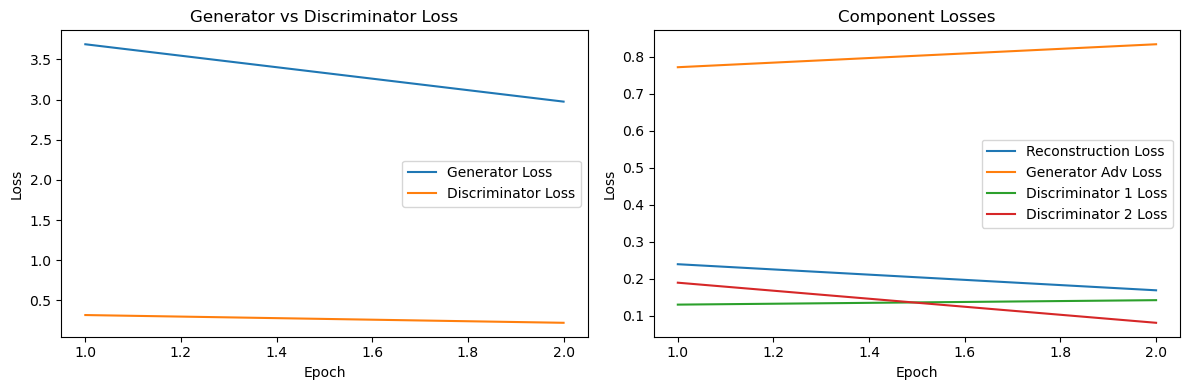

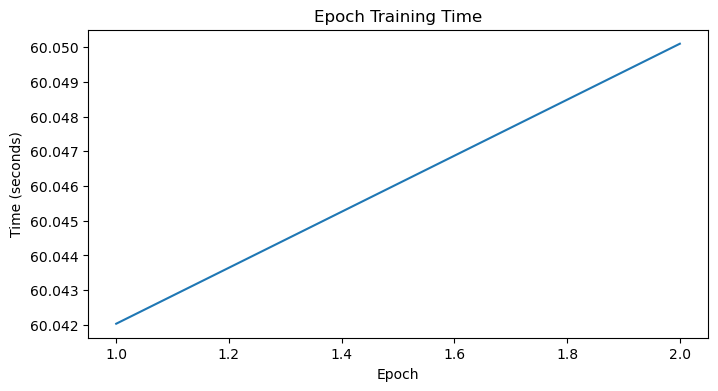

In [ ]:
# %% Cell 5: Configuration and training launch
print("Cell 5: Setup config and start training")

# Config
BATCH_SIZE = 16
LEARNING_RATE = 2e-4
NUM_EPOCHS = 50
IMG_SIZE = (256, 256)
DEVICE = DEVICE
DATASET_PATH = "../Dataset/train"   # change to your folder containing 'ct' and 'mri' subfolders

# Create trainer and start training
if os.path.exists(DATASET_PATH):
    trainer = DDcGANTrainer(
        dataset_path=DATASET_PATH,
        batch_size=BATCH_SIZE,
        lr=LEARNING_RATE,
        img_size=IMG_SIZE,
        device=DEVICE
    )
    print("Trainer initialized, starting training...")
    trainer.train(NUM_EPOCHS, save_interval=1)
else:
    print(f"Dataset path not found: {DATASET_PATH}")
    print("Please organize dataset as: ../Dataset/train/ct/*.png and ../Dataset/train/mri/*.png")


Cell 6: Test / demo generator output (uses checkpoint if available)
Loaded checkpoint: checkpoints/intermediate/ddcgan_fusion/ddcgan_epoch_2.pth


/tmp/ipykernel_17950/2879669319.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(checkpoint_path, map_location=DEVICE)


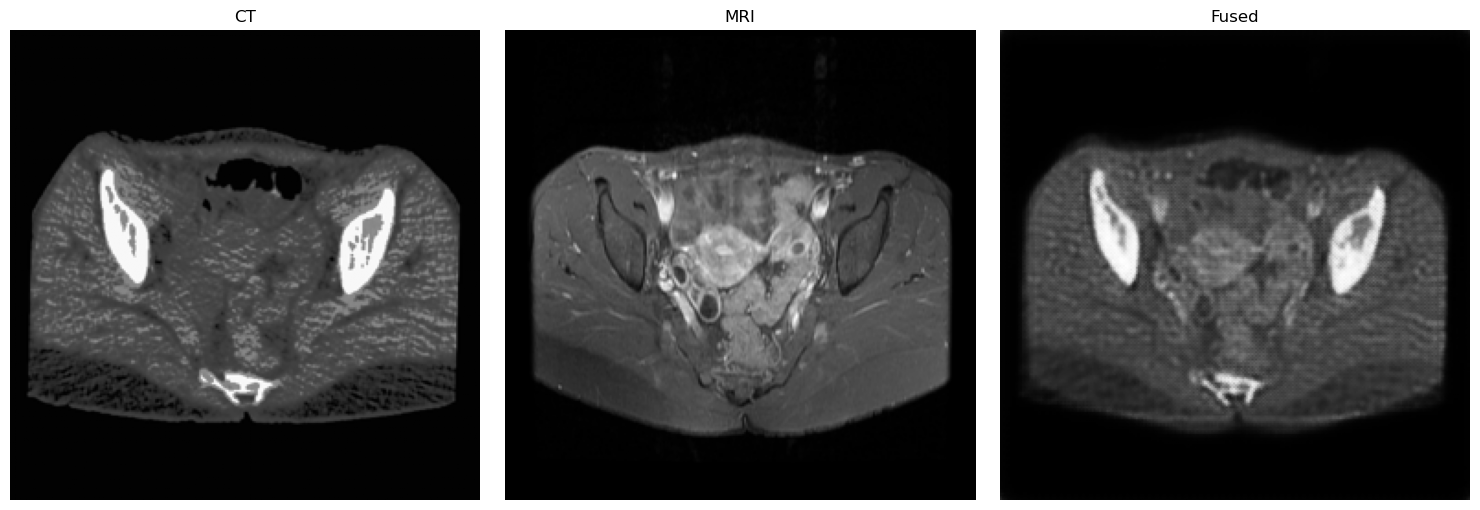

Saved demo: results/ddcgan_fusion/test_demonstration.png


In [9]:
# %% Cell 6: Testing/demo utility (run even without checkpoints)
print("Cell 6: Test / demo generator output (uses checkpoint if available)")

def load_test_image_pair(dataset_path=DATASET_PATH, img_size=IMG_SIZE):
    # Try to load first sample from dataset; else produce dummy
    try:
        ds = CTMRIDataset(dataset_path, transform=transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x*2-1)]), img_size=img_size)
        ct, mri = ds[54]
        return ct.unsqueeze(0), mri.unsqueeze(0)
    except Exception as e:
        print("Could not load from dataset, using dummy tensors:", e)
        dummy_ct = torch.rand(1,1,img_size[0], img_size[1]) * 2 - 1
        dummy_mri = torch.rand(1,1,img_size[0], img_size[1]) * 2 - 1
        return dummy_ct, dummy_mri

def test_model(checkpoint_path=None):
    gen = Generator(in_channels=2, out_channels=1).to(DEVICE)
    if checkpoint_path and os.path.exists(checkpoint_path):
        ckpt = torch.load(checkpoint_path, map_location=DEVICE)
        gen.load_state_dict(ckpt['generator_state_dict'])
        print("Loaded checkpoint:", checkpoint_path)
    else:
        print("No checkpoint provided or file missing. Using untrained generator for demo.")

    gen.eval()
    ct_img, mri_img = load_test_image_pair()
    ct_img = ct_img.to(DEVICE)
    mri_img = mri_img.to(DEVICE)
    input_img = torch.cat([ct_img, mri_img], dim=1)
    with torch.no_grad():
        fused = gen(input_img)
    # Denormalize to [0,1]
    ct_d = ((ct_img.cpu().squeeze() + 1) / 2).numpy()
    mri_d = ((mri_img.cpu().squeeze() + 1) / 2).numpy()
    fused_d = ((fused.cpu().squeeze() + 1) / 2).numpy()

    fig, axes = plt.subplots(1,3,figsize=(15,5))
    axes[0].imshow(ct_d, cmap='gray'); axes[0].set_title('CT'); axes[0].axis('off')
    axes[1].imshow(mri_d, cmap='gray'); axes[1].set_title('MRI'); axes[1].axis('off')
    axes[2].imshow(fused_d, cmap='gray'); axes[2].set_title('Fused'); axes[2].axis('off')
    plt.tight_layout()
    os.makedirs(RESULTS_DIR, exist_ok=True)
    plt.savefig(f'{RESULTS_DIR}/test_demonstration.png', dpi=150, bbox_inches='tight')
    plt.show()
    print(f"Saved demo: {RESULTS_DIR}/test_demonstration.png")

# Try to find latest checkpoint
ckpt_candidates = []
if os.path.exists(CHECKPOINTS_DIR):
    ckpt_candidates += [os.path.join(CHECKPOINTS_DIR, f) for f in os.listdir(CHECKPOINTS_DIR) if f.endswith('.pth')]
if os.path.exists(FINAL_MODELS_DIR):
    ckpt_candidates += [os.path.join(FINAL_MODELS_DIR, f) for f in os.listdir(FINAL_MODELS_DIR) if f.endswith('.pth')]

if len(ckpt_candidates) > 0:
    ckpt_candidates.sort()
    latest = ckpt_candidates[-1]
    test_model(latest)
else:
    print("No checkpoint found. Running demo with untrained generator.")
    test_model(None)
